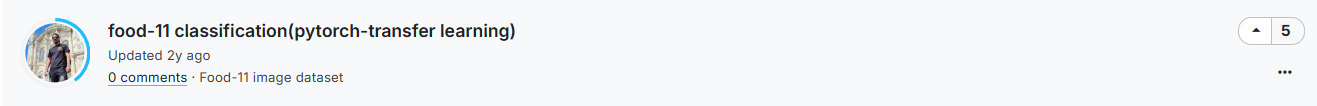

In [1]:
import os
import numpy as np
import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
ROOT_PATH = r"D:\code_study\ML_CODE\dataSets\Classification\Food_11_image_dataset\archive"
ROOT_PATH = ROOT_PATH.replace("\\", "/")

training_path = f'{ROOT_PATH}/training'
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
batch_size = 32
image_size = 224

In [5]:
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]

In [6]:
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

In [7]:
model = models.resnet101(pretrained=True)

c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Leaper/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [11:22<00:00, 262kB/s] 


In [8]:
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, 11, device)

In [9]:
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

In [11]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)

In [12]:
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

In [14]:
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4543533266575537e-08..1.0000000326633454].


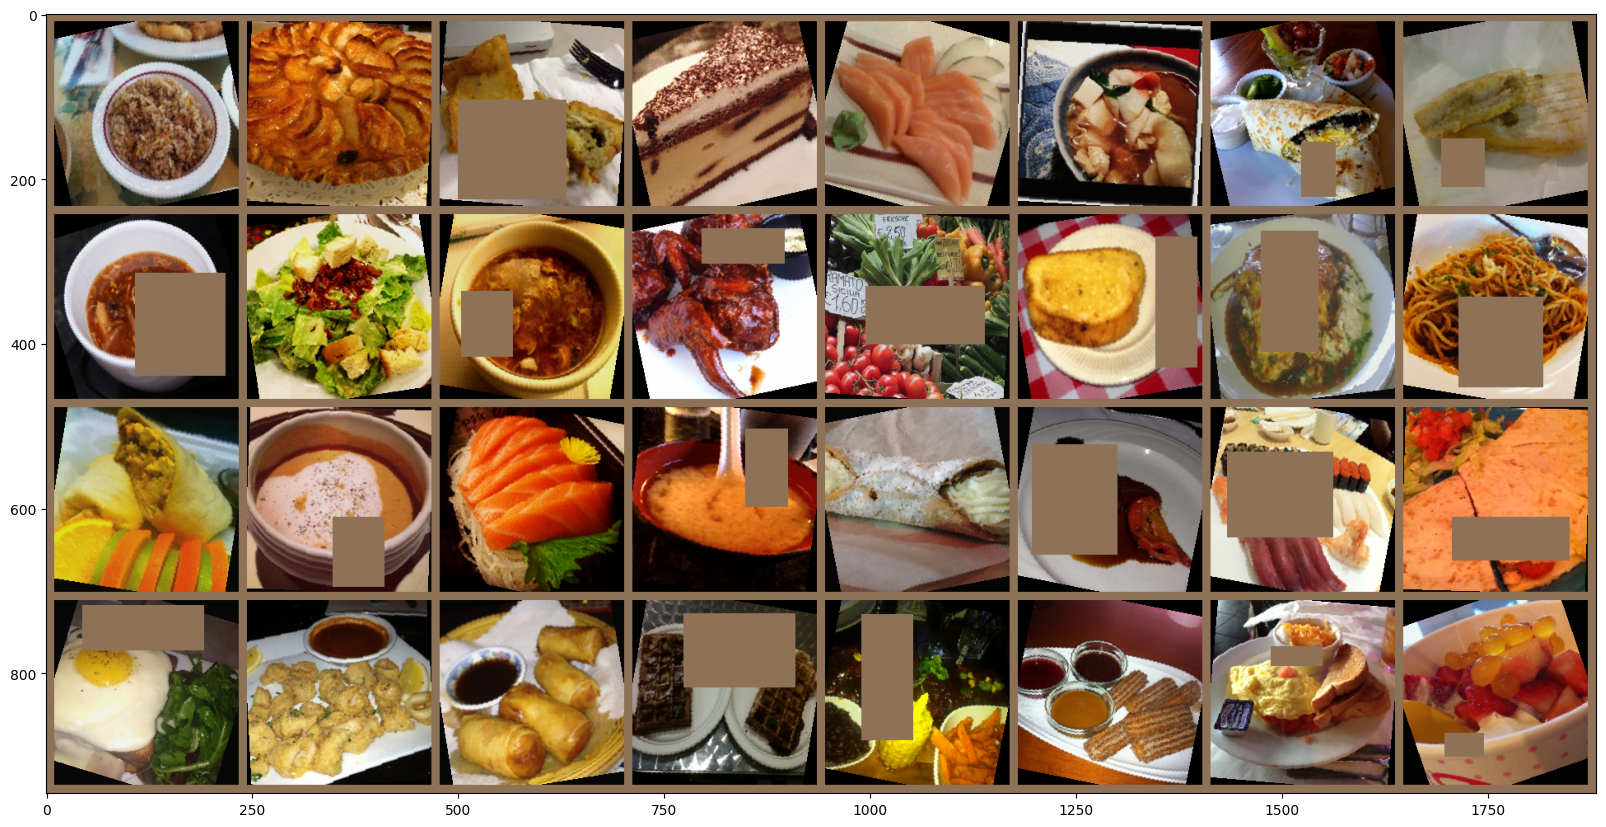

In [15]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

In [16]:
%%time

num_epochs = 15
losses = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))

Epoch [ 1/15], Step [ 50/308], Loss: 1.3780
Epoch [ 1/15], Step [100/308], Loss: 1.1016
Epoch [ 1/15], Step [150/308], Loss: 0.4618
Epoch [ 1/15], Step [200/308], Loss: 0.5340
Epoch [ 1/15], Step [250/308], Loss: 0.3942
Epoch [ 1/15], Step [300/308], Loss: 0.2193
Epoch [ 2/15], Step [ 50/308], Loss: 0.8356
Epoch [ 2/15], Step [100/308], Loss: 0.1735
Epoch [ 2/15], Step [150/308], Loss: 0.3714
Epoch [ 2/15], Step [200/308], Loss: 0.4087
Epoch [ 2/15], Step [250/308], Loss: 0.3262
Epoch [ 2/15], Step [300/308], Loss: 0.5287
Epoch [ 3/15], Step [ 50/308], Loss: 0.5133
Epoch [ 3/15], Step [100/308], Loss: 0.1859
Epoch [ 3/15], Step [150/308], Loss: 0.3812
Epoch [ 3/15], Step [200/308], Loss: 0.2977
Epoch [ 3/15], Step [250/308], Loss: 0.2612
Epoch [ 3/15], Step [300/308], Loss: 0.2000
Epoch [ 4/15], Step [ 50/308], Loss: 0.2016
Epoch [ 4/15], Step [100/308], Loss: 0.1860
Epoch [ 4/15], Step [150/308], Loss: 0.3348
Epoch [ 4/15], Step [200/308], Loss: 0.0793
Epoch [ 4/15], Step [250/308], L

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


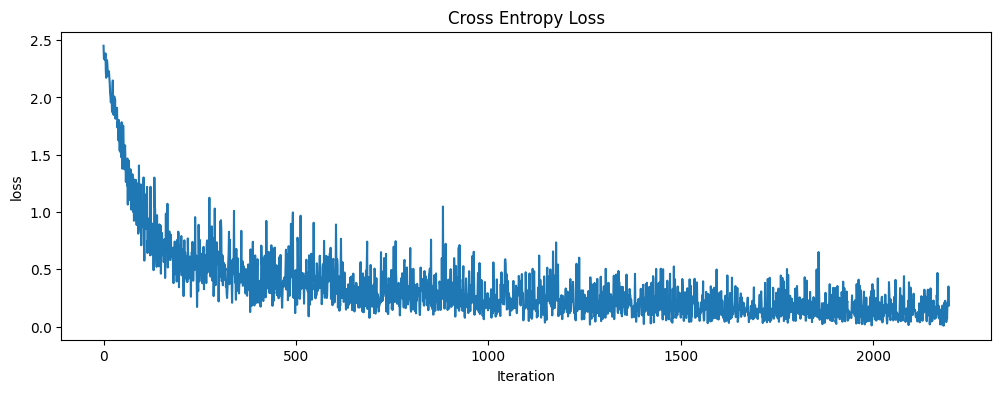

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [18]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [19]:
evaluate_model(model, train_dataloader, device)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
evaluate_model(model, evaluation_dataloader, device)